# QISKIT Lab 7 - VQE Born-Oppenheimer Potential Energy Surface of H2 and LiH
1. **S. G. Nana Engo**, serge.nana-engo@facsciences-uy1.cm
    * Department of Physics, Faculty of Science, University of Yaounde I
1. **J-P. Tchapet Njafa**, jean-pierre.tchapet@facsciences-uy1.cm
    * Department of Physics, Faculty of Science, University of Maroua

       
April 2023

Nous allons examiner comment utiliser l'algorithme d'échantillonnage de surface d'énergie potentielle (PES) pour générer le profil de dissociation de la molécule d'hydrogène. Il s'agit de représenter la variation de l'énergie en ofnction de la distance interatomique. Nous utilisons la surface d'énergie potentielle de Born-Oppenheimer (BOPES).

In [2]:
from qiskit_nature.units import DistanceUnit
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.second_q.transformers import FreezeCoreTransformer

from qiskit_nature.second_q.mappers import (
    ParityMapper, 
    JordanWignerMapper,
    BravyiKitaevMapper,
    QubitConverter
)
from qiskit.primitives import Estimator
from qiskit.algorithms.optimizers import SPSA, SLSQP, L_BFGS_B
from qiskit_nature.second_q.circuit.library import HartreeFock, UCCSD
from qiskit.algorithms.minimum_eigensolvers import (
    NumPyMinimumEigensolver, 
    VQE, 
    AdaptVQE
)
from qiskit_nature.second_q.algorithms import GroundStateEigensolver, VQEUCCFactory

from openfermion.chem import MolecularData
from openfermionpyscf import PyscfMolecularData

import numpy as np
import matplotlib.pyplot as plt

In [4]:
from functools import reduce

import numpy as np
from pyscf import gto, scf, ao2mo, ci, cc, fci, mp, mcscf
from pyscf.mcscf import avas #AVAS method to construct mcscf active space


from qiskit_nature_pyscf import QiskitSolver

### Structure de la Molécule

In [18]:
def prepare_pyscf_molecule(molecule):
    """
    This function creates and saves a pyscf input file.

    Args:
        molecule: An instance of the MolecularData class.

    Returns:
        pyscf_molecule: A pyscf molecule instance.
    """
    pyscf_molecule = gto.Mole()
    pyscf_molecule.atom = molecule.geometry
    pyscf_molecule.basis = molecule.basis
    pyscf_molecule.spin = molecule.multiplicity - 1
    pyscf_molecule.charge = molecule.charge
    pyscf_molecule.symmetry = False
    pyscf_molecule.build()

    return pyscf_molecule

### Calculs Hartree-Fock

In [19]:

def compute_scf(pyscf_molecule):
    """
    Perform a Hartree-Fock calculation.

    Args:
        pyscf_molecule: A pyscf molecule instance.

    Returns:
        pyscf_scf: A PySCF "SCF" calculation object.
    """
    if pyscf_molecule.spin:
        pyscf_scf = scf.ROHF(pyscf_molecule)
    else:
        pyscf_scf = scf.RHF(pyscf_molecule)
    return pyscf_scf

### Calculs des intégrales à 1-électrons et 2-électrons

In [24]:
def compute_integrals(pyscf_molecule, pyscf_scf):
    """
    Compute the 1-electron and 2-electron integrals.

    Args:
        pyscf_molecule: A pyscf molecule instance.
        pyscf_scf: A PySCF "SCF" calculation object.

    Returns:
        one_electron_integrals: An N by N array storing h_{pq}
        two_electron_integrals: An N by N by N by N array storing h_{pqrs}.
    """
    # Get one electrons integrals.
    n_orbitals = pyscf_scf.mo_coeff.shape[1]
    one_electron_compressed = reduce(np.dot, (pyscf_scf.mo_coeff.T,
                                                 pyscf_scf.get_hcore(),
                                                 pyscf_scf.mo_coeff))
    one_electron_integrals = one_electron_compressed.reshape(
        n_orbitals, n_orbitals).astype(float)

    # Get two electron integrals in compressed format.
    two_electron_compressed = ao2mo.kernel(pyscf_molecule,
                                           pyscf_scf.mo_coeff)

    two_electron_integrals = ao2mo.restore(
        1, # no permutation symmetry
        two_electron_compressed, n_orbitals)
    # See PQRS convention uses is h[p,q,r,s] = (ps|qr)
    two_electron_integrals = np.asarray(
        two_electron_integrals.transpose(0, 2, 3, 1), order='C')

    # Return.
    return one_electron_integrals, two_electron_integrals


### Exécution des calculs PySCF

In [33]:
def run_pyscf(molecule,
              run_scf=True,
              run_mp2=False,
              run_cisd=False,
              run_casci=False,
              run_fci=False,
              show=False):
    """
    This function runs a pyscf calculation.

    Args:
        molecule: An instance of the MolecularData or PyscfMolecularData class.
        run_scf: Optional boolean to run SCF calculation.
        run_mp2: Optional boolean to run MP2 calculation.
        run_cisd: Optional boolean to run CISD calculation.
        run_casci: Optional boolean to run casci calculation.
        run_fci: Optional boolean to FCI calculation.
        show: Boolean whether to print calculation results to screen.

    Returns:
        molecule: The updated PyscfMolecularData object. Note the attributes
        of the input molecule are also updated in this function.
    """
    # Prepare pyscf molecule.
    pyscf_molecule = prepare_pyscf_molecule(molecule)
    molecule.n_orbitals = int(pyscf_molecule.nao_nr())
    molecule.n_qubits = 2 * molecule.n_orbitals
    molecule.nuclear_repulsion = float(pyscf_molecule.energy_nuc())

    # Run SCF.
    pyscf_scf = compute_scf(pyscf_molecule)
    pyscf_scf.run()
    molecule.hf_energy = float(pyscf_scf.e_tot)
    if show:
        print(f'Hartree-Fock energy for {molecule.name} ({molecule.n_electrons} electrons) is {molecule.hf_energy}.')

    # Hold pyscf data in molecule. They are required to compute density
    # matrices and other quantities.
    molecule._pyscf_data = pyscf_data = {}
    pyscf_data['mol'] = pyscf_molecule
    pyscf_data['scf'] = pyscf_scf

    # Populate fields.
    molecule.canonical_orbitals = pyscf_scf.mo_coeff.astype(float)
    molecule.orbital_energies = pyscf_scf.mo_energy.astype(float)

    # Get integrals.
    one_body_integrals, two_body_integrals = compute_integrals(
        pyscf_molecule, pyscf_scf)
    molecule.one_body_integrals = one_body_integrals
    molecule.two_body_integrals = two_body_integrals
    molecule.overlap_integrals = pyscf_scf.get_ovlp()

    # Run MP2.
    if run_mp2:
        if molecule.multiplicity != 1:
            print("WARNING: RO-MP2 is not available in PySCF.")
        else:
            pyscf_mp2 = mp.MP2(pyscf_scf)
            pyscf_mp2.run()
            # molecule.mp2_energy = pyscf_mp2.e_tot  # pyscf-1.4.4 or higher
            molecule.mp2_energy = pyscf_scf.e_tot + pyscf_mp2.e_corr
            pyscf_data['mp2'] = pyscf_mp2
            if show:
                print(f'MP2 energy for {molecule.name} ({molecule.n_electrons} electrons) is {molecule.hf_energy}.')

    # Run CISD.
    if run_cisd:
        pyscf_cisd = ci.CISD(pyscf_scf)
        pyscf_cisd.run()
        molecule.cisd_energy = pyscf_cisd.e_tot
        pyscf_data['cisd'] = pyscf_cisd
        if show:
            print(f'CISD energy for {molecule.name} ({molecule.n_electrons} electrons) is {molecule.hf_energy}.')

    # Run casci.
    if run_casci:
        norb, nelec = 2, 2
        pyscf_casci = mcscf.CASCI(pyscf_scf, norb, nelec)
        pyscf_casci.run()
        molecule.casci_energy = pyscf_casci.e_tot
        pyscf_data['CASCI'] = pyscf_casci
        if show:
            print(f'CASCI energy for {molecule.name} ({molecule.n_electrons} electrons) is {molecule.hf_energy}.')

    # Run FCI.
    if run_fci:
        pyscf_fci = fci.FCI(pyscf_molecule, pyscf_scf.mo_coeff)
        molecule.fci_energy = pyscf_fci.kernel()[0]
        pyscf_data['fci'] = pyscf_fci
        if show:
            print(f'FCI energy for {molecule.name} ({molecule.n_electrons} electrons) is {molecule.hf_energy}.')

    # Return updated molecule instance.
    pyscf_molecular_data = PyscfMolecularData.__new__(PyscfMolecularData)
    pyscf_molecular_data.__dict__.update(molecule.__dict__)
    pyscf_molecular_data.save()
    return pyscf_molecular_data


## PES des calculs PySCF

converged SCF energy = -0.46576369202201
E(MP2) = -0.471483763171055  E_corr = -0.00572007114904553
E(RCISD) = -0.4733700032133228  E_corr = -0.007606311191312962
CASCI E = -0.473370003213323  E(CI) = -2.39765077019514  S^2 = 0.0000000

At bond length of 0.275 angstrom, molecular hydrogen has:
Hartree-Fock energy of -0.46576369202200985 Hartree.
MP2 energy of -0.4714837631710554 Hartree.
CISD energy of -0.4733700032133228 Hartree.
CASCI energy of -0.473370003213323 Hartree.
FCI energy of -0.4733700032133239 Hartree.
Nuclear repulsion energy between protons is 1.924280766981818 Hartree.
Spatial orbital 0 has energy of -0.817340000935664 Hartree.
Spatial orbital 1 has energy of 1.4209358488233572 Hartree.
converged SCF energy = -0.780454902071526
E(MP2) = -0.786933019271431  E_corr = -0.00647811719990496
E(RCISD) = -0.7892693924044134  E_corr = -0.008814490332887013
CASCI E = -0.789269392404415  E(CI) = -2.30120428074727  S^2 = 0.0000000

At bond length of 0.35 angstrom, molecular hydrog

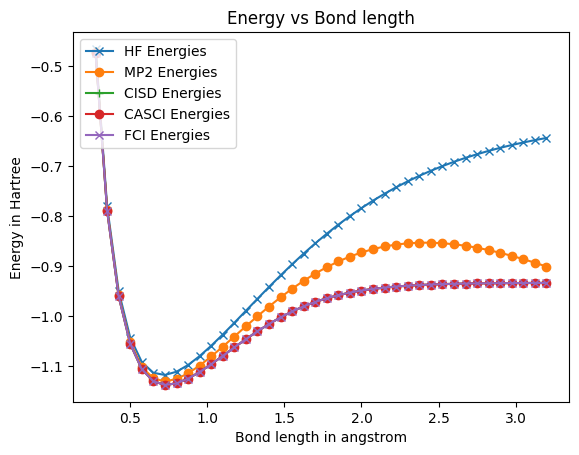

In [36]:
basis = 'sto-3g'
multiplicity = 1
n_points = 40
bond_length_interval = 3.0 / n_points


# Set calculation parameters.
run_scf = 1
run_mp2 = 1
run_cisd = 1
run_casci = 1
run_fci = 1
delete_input = True
delete_output = True

# Generate molecule at different bond lengths.
hf_energies = []
fci_energies = []
mp2_energies = []
casci_energies = []
cisd_energies = []
bond_lengths = []
for point in range(1, n_points + 1):
    bond_length = bond_length_interval * float(point) + 0.2
    bond_lengths += [bond_length]
    geometry = [('H', (0., 0., 0.)), ('H', (0., 0., bond_length))]
    h2_molecule = MolecularData(
        geometry, basis, multiplicity,
        description=str(round(bond_length, 2)))
    
    # Run pyscf.
    h2_molecule = run_pyscf(h2_molecule,
                         run_scf=run_scf,
                         run_mp2=run_mp2,
                         run_cisd=run_cisd,
                         run_casci=run_casci,
                         run_fci=run_fci)

    # Print out some results of calculation.
    print(f'\nAt bond length of {bond_length} angstrom, molecular hydrogen has:')
    print(f'Hartree-Fock energy of {h2_molecule.hf_energy} Hartree.')
    print(f'MP2 energy of {h2_molecule.mp2_energy} Hartree.')
    print(f'CISD energy of {h2_molecule.cisd_energy} Hartree.')
    print(f'CASCI energy of {h2_molecule.casci_energy} Hartree.')
    print(f'FCI energy of {h2_molecule.fci_energy} Hartree.')
    print(f'Nuclear repulsion energy between protons is {h2_molecule.nuclear_repulsion} Hartree.')
    # for orbital in range(h2_molecule.n_orbitals):
    #     print(f'Spatial orbital {orbital} has energy of {h2_molecule.orbital_energies[orbital]} Hartree.')
    hf_energies += [h2_molecule.hf_energy]
    mp2_energies += [h2_molecule.mp2_energy]
    cisd_energies += [h2_molecule.cisd_energy]
    casci_energies += [h2_molecule.casci_energy]
    fci_energies += [h2_molecule.fci_energy]

# Plot.
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(0)
plt.plot(bond_lengths, hf_energies, 'x-',label='HF Energies')
plt.plot(bond_lengths, mp2_energies, 'o-',label='MP2 Energies')
plt.plot(bond_lengths, cisd_energies, '+-',label='CISD Energies')
plt.plot(bond_lengths, casci_energies, 'w-',label='CASCI Energies')
plt.plot(bond_lengths, fci_energies, 'x-',label='FCI Energies')

plt.ylabel('Energy in Hartree')
plt.xlabel('Bond length in angstrom')
plt.legend(loc=9)
plt.title('Energy vs Bond length')

plt.show()


Les PES de la figure ci-dessus mettent en évidence une quasi identité des résultats CISD, CASCI et FCI. Pour la suite, nous allons utiliser la méthode CASCI qui est moins consomatrice des ressources que la FCI. 

In [5]:
from qiskit.quantum_info import SparsePauliOp

H2_op = SparsePauliOp.from_list(
    [
        ("II", -1.052373245772859),
        ("IZ", 0.39793742484318045),
        ("ZI", -0.39793742484318045),
        ("ZZ", -0.01128010425623538),
        ("XX", 0.18093119978423156),
    ]
)

# we will iterate over these different optimizers
optimizers = [SPSA(maxiter=100), L_BFGS_B(maxiter=100), SLSQP(maxiter=100)]
converge_counts = np.empty([len(optimizers)], dtype=object)
converge_vals = np.empty([len(optimizers)], dtype=object)

for i, optimizer in enumerate(optimizers):
    print("\rOptimizer: {}        ".format(type(optimizer).__name__), end="")
    # algorithm_globals.random_seed = 50

    counts = []
    values = []

    def store_intermediate_result(eval_count, parameters, mean, std):
        counts.append(eval_count)
        values.append(mean)

    vqe = VQE(Estimator(), UCCSD(), optimizer, callback=store_intermediate_result)
    result = vqe.compute_minimum_eigenvalue(operator=H2_op)
    converge_counts[i] = np.asarray(counts)
    converge_vals[i] = np.asarray(values)

print("\rOptimization complete      ");

Optimizer: SPSA        

AlgorithmError: 'The number of qubits of the ansatz does not match the operator, and the ansatz does not allow setting the number of qubits using `num_qubits`.'

## Plugin `qiskit_nature_solver`

In [ ]:
def algorithm(mapper, optimizer):
    
    mapper = mapper
    optimizer = optimizer

    converter = QubitConverter(mapper, two_qubit_reduction=True)
    
    vqe_solver = VQEUCCFactory(Estimator(), UCCSD(), optimizer)
  
    algorithm = GroundStateEigensolver(converter, vqe_solver)
    
    return algorithm

In [301]:
H2_driver = PySCFDriver(
    atom="H 0 0 0; H 0 0 0.735",
    basis="sto3g",
    charge=0,
    spin=0,
    unit=DistanceUnit.ANGSTROM,
)

# Electronic structure problem
H2_problem = H2_driver.run()
transformer = FreezeCoreTransformer()
H2_problem = transformer.transform(H2_problem)

In [308]:
def run_vqe(name, problem, mapper, optimizer, show=False):
    """Computing of the molecular ground state with the class `GroundStateEigensolver`

    Args:
        name (str):  a string of characters to be printed, such as 'NumPy exact solver'

        problem :  Electronic structure problem

        mapper : Mapper string that can be "Parity" or "JordanWigner" or "Bravyi-Kitaev"
        
        optimizer :  Optimizer string that can be either "SPSA" or "SLSQP" or "L_BFGS_B"
       
    Returns:
          The ground state of the molecule

    """    
    # Mapper
    dmap = {"Jordan-Wigner": JordanWignerMapper(), "Parity": ParityMapper(),  "Bravyi-Kitaev": BravyiKitaevMapper()}
    for k, v in dmap.items():
        if k == mapper:        
            q_conv = qubit_converter(v)
    
    # Optimizer
    dopt = {"SPSA": SPSA(), "SLSQP": SLSQP(), "L_BFGS_B": L_BFGS_B()}
    for n, m in dopt.items():
        if n == optimizer:        
            vqe_factory = VQEUCCFactory(estimator=Estimator(), ansatz=UCCSD(), optimizer=m)
      
    # Ground state computation using a minimum eigensolver. Returns the solver.
    Algo = GroundStateEigensolver(q_conv, vqe_factory) 
    
    # Compute Ground State properties.
    ground_state = Algo.solve(problem)
    if show:
        print(f'Running the VQE using the {name} and {mapper} transformation with {optimizer} optimize')
        print(f'Elapsed time: {elapsed} \n')
        print(ground_state.total_energies[0])
    return ground_state


A cet effet, nous définissons une fonction `get_qubit_op()` qui prend une distance interatomique et renvoie l'opérateur qubit $\mathtt{H}$ approprié, ainsi que d'autres informations sur l'opérateur.

In [ ]:
backend = BasicAer.get_backend("statevector_simulator")
distances = np.arange(0.5, 4.0, 0.2)


In [ ]:
# Sampling the potential energy surface
_EPS = 1e-2 # Global variable used to chop small numbers to zero
def bopes(info_dict, mapper, num_electrons, num_spatial_orbitals, two_qubit_reduction, z2symmetry_reduction,
          name_solver, perturbation_steps, qubit_converter, solver, show=True):
    
exact_energies = []
vqe_energies = []
optimizer = SLSQP(maxiter=5)
for dist in distances:
    # Define Molecule
    molecule = Molecule(
        # Coordinates in Angstrom
        geometry=[
            ["Li", [0.0, 0.0, 0.0] ],
            ["H", [dist, 0.0, 0.0] ]
        ],
        multiplicity=1,  # = 2*spin + 1
        charge=0,
    )
    (qubit_op, num_particles, num_spin_orbitals,
                             problem, converter) = get_qubit_op(molecule,
                                                                mapper,
                                                                [FreezeCoreTransformer(
                                                                    freeze_core=True,
                                                                    remove_orbitals=[-3,-2])])
    result = exact_solver(problem,converter)
    exact_energies.append(result.total_energies[0].real)
    init_state = HartreeFock(num_spin_orbitals, num_particles, converter)
    var_form = qiskit_nature.circuit.library.UCCSD(converter,
                     num_particles,
                     num_spin_orbitals,
                     initial_state=init_state)
    vqe = VQE(var_form, optimizer, quantum_instance=backend,callback=store_intermediate_result)
    vqe_calc = vqe.compute_minimum_eigenvalue(qubit_op)
    vqe_result = problem.interpret(vqe_calc).total_energies[0].real
    vqe_energies.append(vqe_result)
    
if show: 
    plt.plot(distances, exact_energies, label="Exact Energy")
    plt.plot(distances, vqe_energies, label="VQE Energy")
    plt.xlabel('Atomic distance (Angstrom)')
    plt.ylabel('Energy')
    plt.legend()
    plt.show()

In [ ]:
# Display Qiskit Software and System information
import qiskit.tools.jupyter
%qiskit_version_table